In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import astropy.io.fits as fits
from astropy import units as u
from collections import defaultdict

In [2]:
import DPConCFil
from DPConCFil.Clump_Class import *
from DPConCFil.Filament_Class import *
import DPConCFil.Plot_and_Save_Funs as Plot_and_Save_Funs
import DPConCFil.Profile_Funs as Profile_Funs

## The reference of the Example data 

'Example_Filaments_13CO_1.fits' is the $^{13}CO$ ($J = 1-0$) emission line of the Milky Way Imaging Scroll Painting (MWISP) within $17.7^{\circ} \leq l \leq 18.5^{\circ}$, $0^{\circ} \leq b \leq 0.8^{\circ}$ and 5 km s$^{-1}$ $\leq v \leq$ 30 km s$^{-1}$. 

MWISP project is a multi-line survey in $^{12}CO$/$^{13}CO$/$C^{18}O$ along the northern galactic plane with PMO-13.7m telescope.

In [3]:
file_example = 'Example_Filaments_13CO_1'
file_name = "../Example_Files/Data/{}.fits".format(file_example)

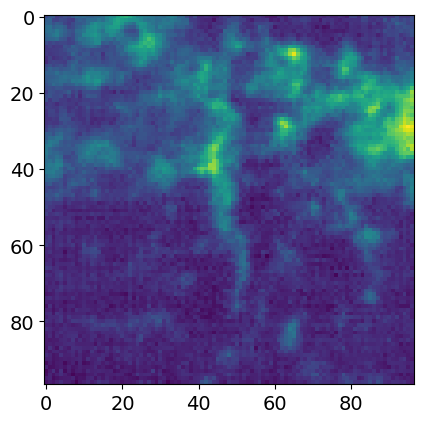

In [4]:
real_data = fits.getdata(file_name)
plt.imshow(real_data.sum(0))
plt.show()

## Calculate the clump information

The parameters of FacetClumps. Please see the introduction of [FacetClumps](https://github.com/JiangYuTS/FacetClumps/blob/master/Examples/Examples_Files_FacetClumps.ipynb) for more details.

In [5]:
SWindow = 3 # [3,5,7]
KBins = 35 # [10,...,60]
FwhmBeam = 2
VeloRes = 2
SRecursionLBV = [9, 4] # [(2+FwhmBeam)**2,3+VeloRes]

header = fits.getheader(file_name)
RMS = header['RMS']
Threshold = 5 * RMS

parameters_FacetClumps = [RMS, Threshold, SWindow, KBins, FwhmBeam, VeloRes, SRecursionLBV]

Construct clump objects. These file names are necessary parameters.

**file_name**: File name.

**mask_name**: Mask name, the file use to store the region information or store the region information. 

**outcat_name**: The file used to store clump table in pixel coordinate system.

**outcat_wcs_name**: The file used to store clump table in WCS coordinate system.

In [6]:
mask_name = '../Example_Files/Clump/mask_{}.fits'.format(file_example)
outcat_name = '../Example_Files/Clump/outcat_{}.csv'.format(file_example)
outcat_wcs_name = '../Example_Files/Clump/outcat_wcs_{}.csv'.format(file_example)

In [7]:
clumpsObj = ClumpInfor(file_name,mask_name,outcat_name,outcat_wcs_name)

### Calculate the clump information from FacetClumps. 

In this case, the parameters of FacetClumps is essential. More clump detection algorithms can also be added to this process. 

The angle of the clumps detected by FacetClumps is obtained by diagonalizing the moment of inertia matrix, please the article of [FacetClumps](https://iopscience.iop.org/article/10.3847/1538-4365/acda89) for more details. Performing a two-dimensional single Gaussian fitting on the velocity integrated map of a clump can provide more accurate position and direction information of the clump in spatial direction. 

When 'fit_flag=True', it indicates that the fitting will be used. This will benefit the performance of DPConFil.

In [8]:
clumpsObj.Cal_Infor_From_Mask_Or_Algorithm(mask_or_algorithm='FacetClumps',parameters=parameters_FacetClumps)
clumpsObj.Get_Clumps_Infor(fit_flag = True)

100%|██████████| 39/39 [00:00<00:00, 180.08it/s]


Number: 126
Time: 10.44


100%|██████████| 126/126 [00:01<00:00, 70.30it/s]

Fitting Clumps Time: 1.8


### Calculate the clump information from the mask file 'mask_name'. 

The mask is the region information of clumps, which can be obtained by any clump detection algorithm.

In [9]:
clumpsObj.Cal_Infor_From_Mask_Or_Algorithm(mask_or_algorithm='mask')
clumpsObj.Get_Clumps_Infor(fit_flag = True)

Number: 126
Time: 0.07


100%|██████████| 126/126 [00:01<00:00, 70.51it/s]

Fitting Clumps Time: 1.8


Plot the original image. If save_path=None, the image will not be saved.

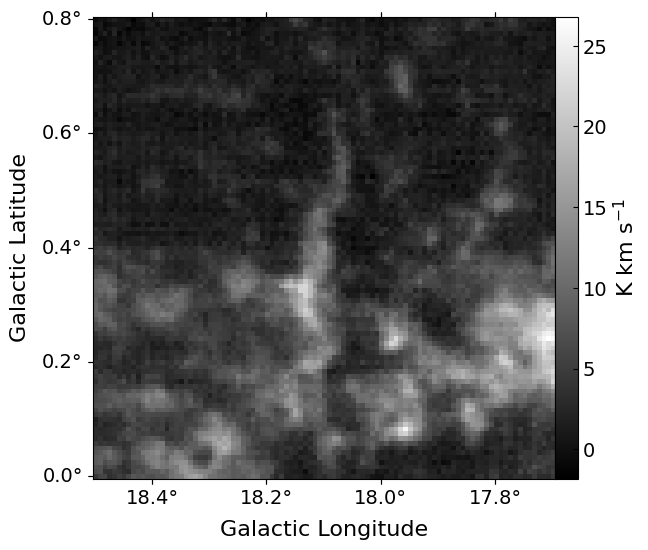

In [10]:
save_path = '../Images/Example_Data.pdf'
Plot_and_Save_Funs.Plot_Origin_Data(clumpsObj,figsize=(8,6),fontsize=16,spacing=12*u.arcmin,save_path=None)

Plot the detection results and save the image. 

The total number of clumps is 127, with 89 of them not touching the edge. The red asterisks denote the central position of the clumps, and the red lines denote the direction of the principal axis of the clumps.

In [11]:
edges = clumpsObj.edges
print('Total number:',len(edges))
print('NO edges number:',np.where(edges==0)[0].shape[0])

Total number: 126
NO edges number: 88


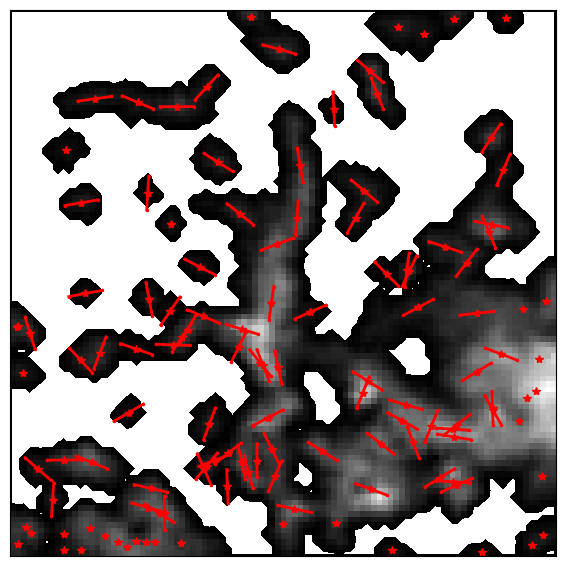

In [12]:
save_path = '../Images/Clumps_Infor.pdf'
Plot_and_Save_Funs.Plot_Clumps_Infor(clumpsObj,figsize=(8,6),line_scale=3,save_path=None)

Get the clumps information from the clumpsObj.

In [13]:
centers = clumpsObj.centers
centers_wcs = clumpsObj.centers_wcs
angles = clumpsObj.angles
origin_data = clumpsObj.origin_data
regions_data = clumpsObj.regions_data
data_wcs = clumpsObj.data_wcs
edges = clumpsObj.edges
clump_coords_dict = clumpsObj.clump_coords_dict
clumps_data = np.zeros_like(origin_data)
clumps_data[regions_data>0] = origin_data[regions_data>0]

### The Algorithm in the PPV Space: MST

In [14]:
centers_file = '../Example_Files/Clump/Example_LBV.dat'
np.savetxt(centers_file, centers_wcs, fmt='%0.3f')

In [15]:
l1,l2 = centers_wcs[:,0].min()-0.2, centers_wcs[:,0].max()+0.2

my_dL = .1
my_dV = 2

filename = centers_file

The original code of MST.

plotting branch has # of clumps: 14
[[ 64  60]
 [ 60  62]
 [ 62  63]
 [ 64 117]
 [ 60  59]
 [ 59  61]
 [ 63 113]
 [113 100]
 [100  99]
 [ 99 101]
 [101 102]
 [102 103]
 [103 110]]
plotting branch has # of clumps: 40
[[  9  23]
 [ 23  24]
 [ 23  22]
 [  9  12]
 [ 12  13]
 [ 22  25]
 [  9   5]
 [  5   6]
 [  6   3]
 [  3   8]
 [  6   4]
 [  4   7]
 [  7  10]
 [ 10  18]
 [ 18  19]
 [ 18  20]
 [ 19  21]
 [ 21  84]
 [ 84  88]
 [ 84  85]
 [ 88  89]
 [ 84  81]
 [ 81  86]
 [ 81  79]
 [ 79  78]
 [ 86  80]
 [ 80  82]
 [ 82  83]
 [ 82  95]
 [ 95  93]
 [ 93  94]
 [ 86  87]
 [ 94 104]
 [104  91]
 [ 91  90]
 [ 94  96]
 [ 96  98]
 [ 98  97]
 [ 89  92]]
plotting branch has # of clumps: 44
[[105  56]
 [ 56  57]
 [ 57  65]
 [ 65  66]
 [ 66  67]
 [ 56  33]
 [ 33  32]
 [ 57  54]
 [ 54  55]
 [ 55  35]
 [ 35  38]
 [ 38  37]
 [ 37  58]
 [ 58  48]
 [ 58  47]
 [ 47  11]
 [ 47  43]
 [ 43  40]
 [ 43  45]
 [ 45  41]
 [ 41  42]
 [ 35  34]
 [ 55  53]
 [ 41  46]
 [ 46  44]
 [ 44  49]
 [ 53  68]
 [ 58  52]
 [ 46  51]

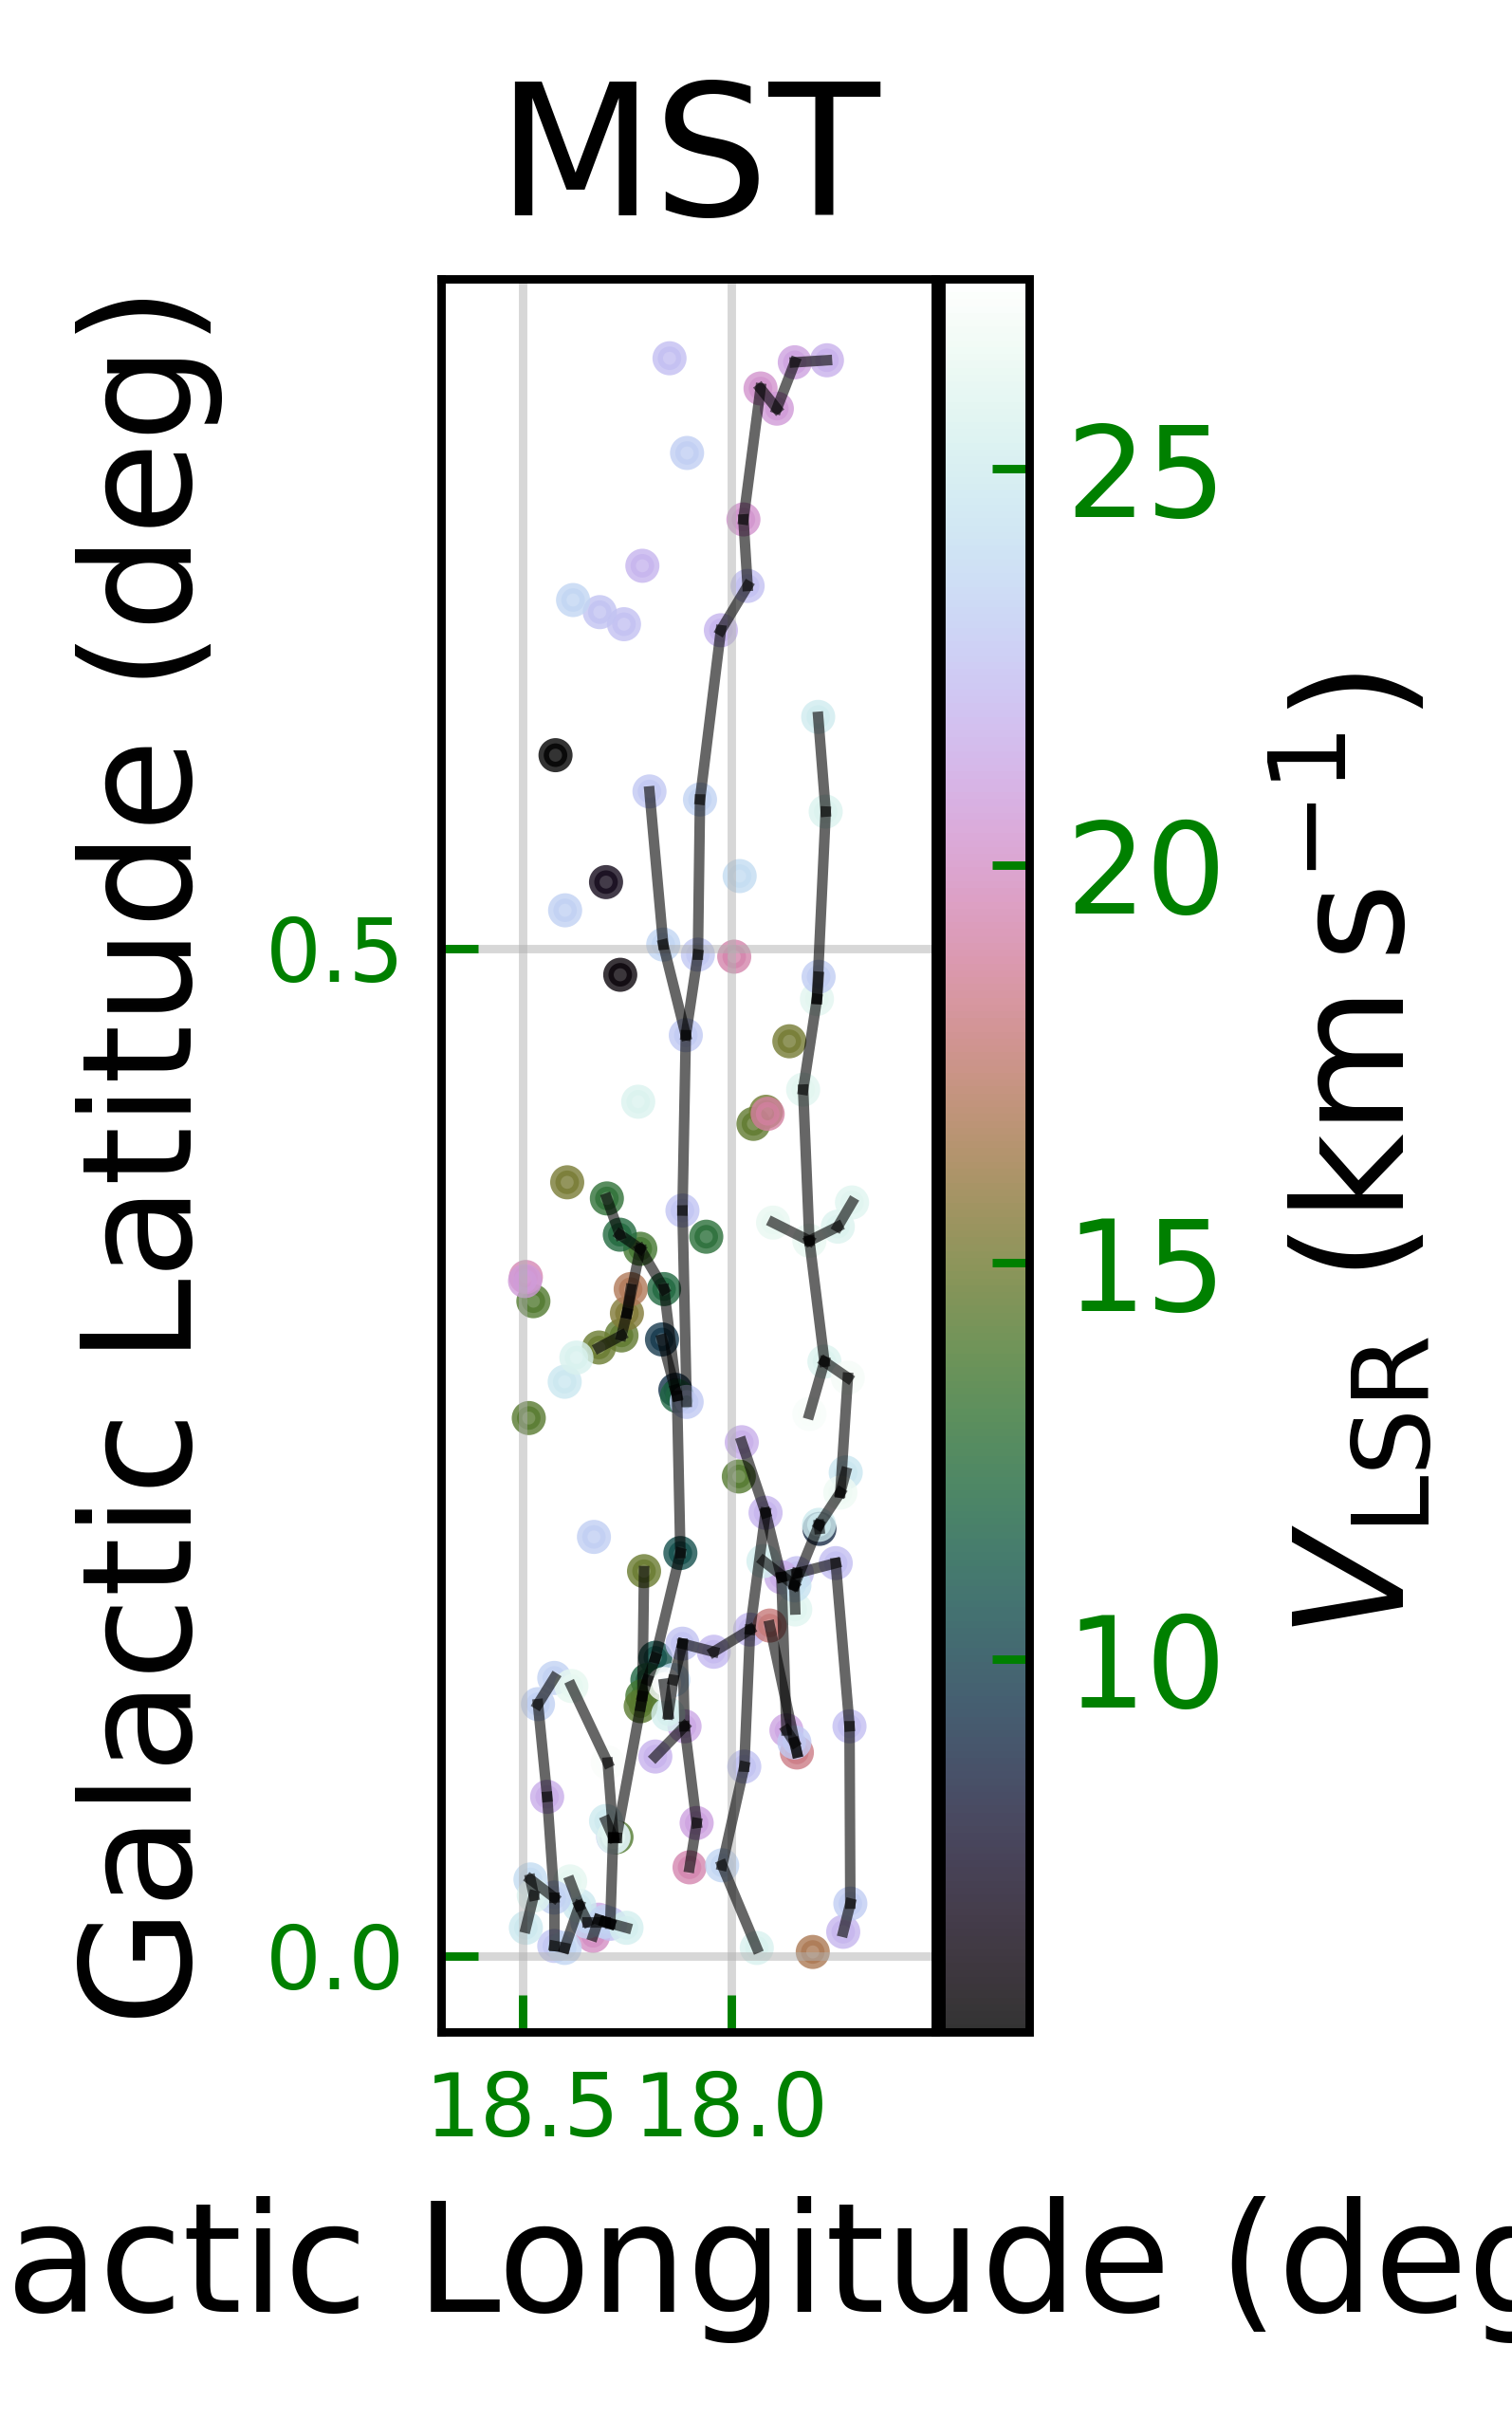

In [16]:

# coding: utf-8

#MST algorithm

#usage

# Alter value of 'l1,l2' to set Galactic longitude range
# Alter value of 'my_dL', 'my_dV' to set critical separation of two connected vertex
# If nodes have no velocity information, please set 'my_dV' to -1.
# Give the path of your table containing Galactic longitude, latitude (and velocity) to 'filename'.



import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
import pickle
from matplotlib.ticker import MultipleLocator, FuncFormatter
import os

def get_lbv(l1=25, l2=26, my_dV=my_dV):
    import numpy as np
    
    fp = open(filename) 
    l=[]
    b=[]
    v=[]
    for linea in fp.readlines():
        linea=linea.strip().split()[:]
        if my_dV == -1:
            v.append(0)
        else:
            try:
                v.append(float(linea[2]))
            except ValueError:
                continue
        l.append(float(linea[0]))
        if l[len(l)-1]>180:
            l[len(l)-1] -= 360
        b.append(float(linea[1])) 
    l = np.array(l)
    b = np.array(b)
    v = np.array(v)     
     
    # mask arrays
    # mask on vlsr
    mv = np.ma.masked_where(v<999, v).mask
    # mask on l
    ml = np.ma.masked_where( (l>l1)&(l<l2), l).mask
    mask = ml*mv
    l = l[mask]
    b = b[mask]
    v = v[mask]
     
    # form 3d and 2d arrays, to be used to generate MST
    lbv = np.zeros( (len(l), 3) )
    lbv[:,0] = l
    lbv[:,1] = b
    lbv[:,2] = v
    lb = lbv[:,0:2]
 
    return lbv
  
def minimum_spanning_tree(X, v, copy_X=True, my_dL=my_dL):
    #X are edge weights of fully connected graph
    if copy_X:
        X = X.copy()
  
    if X.shape[0] != X.shape[1]:
        raise ValueError("X needs to be square matrix of edge weights")
    n_vertices = X.shape[0]
    spanning_edges = []
    break_point = []
      
    # initialize with node 0:                                                                                         
    visited_vertices = [0]                                                                                            
    num_visited = 0
    # exclude self connections:
    diag_indices = np.arange(n_vertices)
    X[diag_indices, diag_indices] = np.inf
      
    while num_visited != n_vertices:
        new_edge = np.argmin(X[visited_vertices], axis=None) 
        # 2d encoding of new_edge from flat, get correct indices
        new_edge = divmod(new_edge, n_vertices) 
        new_edge = [visited_vertices[new_edge[0]], new_edge[1]]
         
        # add edge to tree
        edge_length = np.min(X[visited_vertices])
        dv = abs(v[new_edge[1]] - v[new_edge[0]])
         
        # define conditions to accept edge
        separation = (edge_length < my_dL)
 
        if True:
            if separation:
                spanning_edges.append(new_edge)
            else:
                break_point.append(len(spanning_edges))
        visited_vertices.append(new_edge[1])
        # remove all edges inside current tree
        X[visited_vertices, new_edge[1]] = np.inf
        X[new_edge[1], visited_vertices] = np.inf                                                                     
        num_visited += 1
 
    # now we have a list of spanning_edges, break the list into individual branches
    # build up branch list
    b = break_point
    b = [0]+b # index of first edge element
    b = b+[-1] # index of last edge element
    branch_list = []
    for i in range(0,len(b)-1):
        branch = spanning_edges[ b[i]:b[i+1] ]
        if len(branch) > 3:
            branch_list.append(branch)
    return branch_list
  
def test_mst(l1,l2, my_dV=my_dV):
    lbv = get_lbv(l1=l1, l2=l2, my_dV=my_dV)
    l,b,v = lbv[:,0], lbv[:,1], lbv[:,2]
    P = lbv[:,0:2] # 2d position l,b
    plt.close('all') # close all figures
    plt.figure(figsize=(int(abs(l1-l2)), 3),dpi=800)
    
    if my_dV != -1:
        plt.scatter(P[:, 0], P[:, 1], s=5, c=v, cmap='cubehelix', alpha=.8)
        cb = plt.colorbar(pad=0.01)
        cb.set_label(label=r'$V_\mathrm{LSR} \,\, (\mathrm{km \, s^{-1}})$', fontsize='x-large')
        cb.ax.tick_params(labelsize='large')
    else:
        plt.scatter(P[:, 0], P[:, 1], s=5, c='tan', alpha=.8)
    plt.xlim(l2, l1)
    plt.xlabel('Galactic Longitude (deg)',fontsize='x-large')
    plt.ylabel('Galactic Latitude (deg)',fontsize='x-large')
    plt.grid()
    plt.tick_params(labelsize='small',grid_alpha=0.5,direction='in')
 
 
  
    X = squareform(pdist(P))
    max_length = np.percentile(pdist(P), 25) 
 
    # weight distance with velocity difference
    for i in range(0,X.shape[0]):
        for j in range(0,X.shape[0]):
            dv = abs(v[i] - v[j])
            if (dv > my_dV) & (X[i,j] < 1*my_dL):
                X[i,j] = X[i,j]*dv                 

    branch_list = minimum_spanning_tree(X,v)
    with open("branch_list.dat", 'wb') as f:
        pickle.dump(branch_list, f)
    with open("branch_list.dat", 'rb') as f:
        my_list = pickle.load(f)
 

    # per filament
    for branch in branch_list:
        if len(branch)>1: 
            branch = np.vstack(branch)
        print ('plotting branch has # of clumps:', len(branch)+1)
        print (branch)
 
        # all clumps in this filament
        clump_index = np.unique(np.array(branch))
        ci = clump_index
        l_wt = np.sum( l[ci] * v[ci] ) / np.sum(v[ci])
        b_wt = np.sum( b[ci] * v[ci] ) / np.sum(v[ci])
 
        for edge in branch:
            i, j = edge
            plt.plot([P[i, 0], P[j, 0]], [P[i, 1], P[j, 1]], c='k', lw=1, alpha=.6)
 
    print ('len(branch_list)', len(branch_list))
 
    plt.tight_layout()

    
if __name__ == "__main__":

    test_mst(l1, l2)
    ax = plt.gca()
    ax.xaxis.set_major_locator( MultipleLocator(0.5) )
    ax.yaxis.set_major_locator( MultipleLocator(0.5) )
    plt.title(r'MST',fontsize='xx-large')
    plt.tight_layout()
    if not os.path.isdir('fig'):
        os.makedirs('fig')
#     plt.savefig('fig/demo.pdf')
#     plt.savefig('fig/demo.png')

In [17]:
lbv = get_lbv(l1=l1, l2=l2, my_dV=my_dV)
l,b,v = lbv[:,0], lbv[:,1], lbv[:,2]
P = lbv[:,0:2] # 2d position l,b

X = squareform(pdist(P))
max_length = np.percentile(pdist(P), 25) 

# weight distance with velocity difference
for i in range(0,X.shape[0]):
    for j in range(0,X.shape[0]):
        dv = abs(v[i] - v[j])
        if (dv > my_dV) & (X[i,j] < 1*my_dL):
            X[i,j] = X[i,j]*dv                 

branch_list = minimum_spanning_tree(X,v)
clump_index_record = []
for branch in branch_list:
    if len(branch)>1: 
        branch = np.vstack(branch)
    print ('plotting branch has # of clumps:', len(branch)+1)
    print (branch)
    
    # all clumps in this filament
    clump_indexs = np.unique(np.array(branch))
    clump_index_record.append(clump_indexs)
    ci = clump_indexs
    l_wt = np.sum( l[ci] * v[ci] ) / np.sum(v[ci])
    b_wt = np.sum( b[ci] * v[ci] ) / np.sum(v[ci])

plotting branch has # of clumps: 14
[[ 64  60]
 [ 60  62]
 [ 62  63]
 [ 64 117]
 [ 60  59]
 [ 59  61]
 [ 63 113]
 [113 100]
 [100  99]
 [ 99 101]
 [101 102]
 [102 103]
 [103 110]]
plotting branch has # of clumps: 40
[[  9  23]
 [ 23  24]
 [ 23  22]
 [  9  12]
 [ 12  13]
 [ 22  25]
 [  9   5]
 [  5   6]
 [  6   3]
 [  3   8]
 [  6   4]
 [  4   7]
 [  7  10]
 [ 10  18]
 [ 18  19]
 [ 18  20]
 [ 19  21]
 [ 21  84]
 [ 84  88]
 [ 84  85]
 [ 88  89]
 [ 84  81]
 [ 81  86]
 [ 81  79]
 [ 79  78]
 [ 86  80]
 [ 80  82]
 [ 82  83]
 [ 82  95]
 [ 95  93]
 [ 93  94]
 [ 86  87]
 [ 94 104]
 [104  91]
 [ 91  90]
 [ 94  96]
 [ 96  98]
 [ 98  97]
 [ 89  92]]
plotting branch has # of clumps: 44
[[105  56]
 [ 56  57]
 [ 57  65]
 [ 65  66]
 [ 66  67]
 [ 56  33]
 [ 33  32]
 [ 57  54]
 [ 54  55]
 [ 55  35]
 [ 35  38]
 [ 38  37]
 [ 37  58]
 [ 58  48]
 [ 58  47]
 [ 47  11]
 [ 47  43]
 [ 43  40]
 [ 43  45]
 [ 45  41]
 [ 41  42]
 [ 35  34]
 [ 55  53]
 [ 41  46]
 [ 46  44]
 [ 44  49]
 [ 53  68]
 [ 58  52]
 [ 46  51]

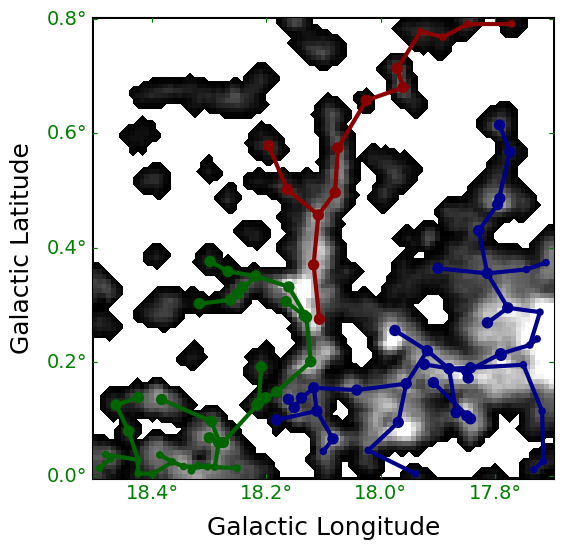

In [18]:
fig = plt.figure(figsize=(8,6))
ax0 = fig.add_subplot(111,projection=data_wcs.celestial)
# fig.tight_layout()

vmin = np.min(clumps_data.sum(0)[np.where(clumps_data.sum(0)!=0)])
vmax = np.nanpercentile(clumps_data.sum(0)[np.where(clumps_data.sum(0)!=0)], 98.)
img = ax0.imshow(clumps_data.sum(0),
                 origin='lower',
           cmap='gray',
           interpolation='none',
           norm = colors.Normalize(vmin = vmin, vmax =  vmax))
ax0.contourf(clumps_data.sum(0),
             levels = [-0.01, .0],
             colors = 'w')

edge_colors = ['darkred','darkgreen','darkblue']
circle_radius = 1
number = 0
for show_id in range(len(clump_index_record)):
    for index in clump_index_record[show_id]:
        center_x = centers[index][1]
        center_y = centers[index][2]
        if edges[index] == 1:
            circle_radius = 0.8
            circle = patches.Circle((center_y, center_x), circle_radius, facecolor=edge_colors[number])
        else :
            circle_radius = 1.2
            circle = patches.Circle((center_y, center_x), circle_radius, facecolor=edge_colors[number])
        ax0.add_patch(circle)
    number += 1

P = centers[:,1:3]
number = 0
for branch in branch_list:
    if len(branch)>1: 
        branch = np.vstack(branch)
        for edge in branch:
            i, j = edge
            ax0.plot([P[i, 1], P[j, 1]],[P[i, 0], P[j, 0]],  c=edge_colors[number], lw=3, alpha=1)    
        number += 1


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.color'] = 'red'
plt.rcParams['ytick.color'] = 'red'
plt.xlabel("Galactic Longitude")
plt.ylabel("Galactic Latitude")
lon = ax0.coords[0]
lat = ax0.coords[1]
lon.set_major_formatter("d.d")
lat.set_major_formatter("d.d")
lon.set_ticks(spacing=12 * u.arcmin)


# plt.savefig('Images/MST_Total.pdf', format='pdf', dpi=1000)
plt.show()


In [19]:
file_name = 'RandA_260_13CO.fits'

file_example = 'Simulation_1'
mask_name = '../Example_Files/Clump/mask_{}.fits'.format(file_example)
outcat_name = '../Example_Files/Clump/outcat_{}.csv'.format(file_example)
outcat_wcs_name = '../Example_Files/Clump/outcat_wcs_{}.csv'.format(file_example)

In [20]:
RMS = 0.1
Threshold = 5 * RMS

parameters_FacetClumps = [RMS, Threshold, SWindow, KBins, FwhmBeam, VeloRes, SRecursionLBV]

In [21]:
clumpsObj = ClumpInfor(file_name,mask_name,outcat_name,outcat_wcs_name)

# clumpsObj.Cal_Infor_From_Mask_Or_Algorithm(mask_or_algorithm='FacetClumps',parameters=parameters_FacetClumps)
# clumpsObj.Get_Clumps_Infor(fit_flag = True)

clumpsObj.Cal_Infor_From_Mask_Or_Algorithm(mask_or_algorithm='mask')
clumpsObj.Get_Clumps_Infor(fit_flag = True)

Number: 373
Time: 0.69


100%|██████████| 373/373 [00:07<00:00, 48.69it/s]

Fitting Clumps Time: 7.95


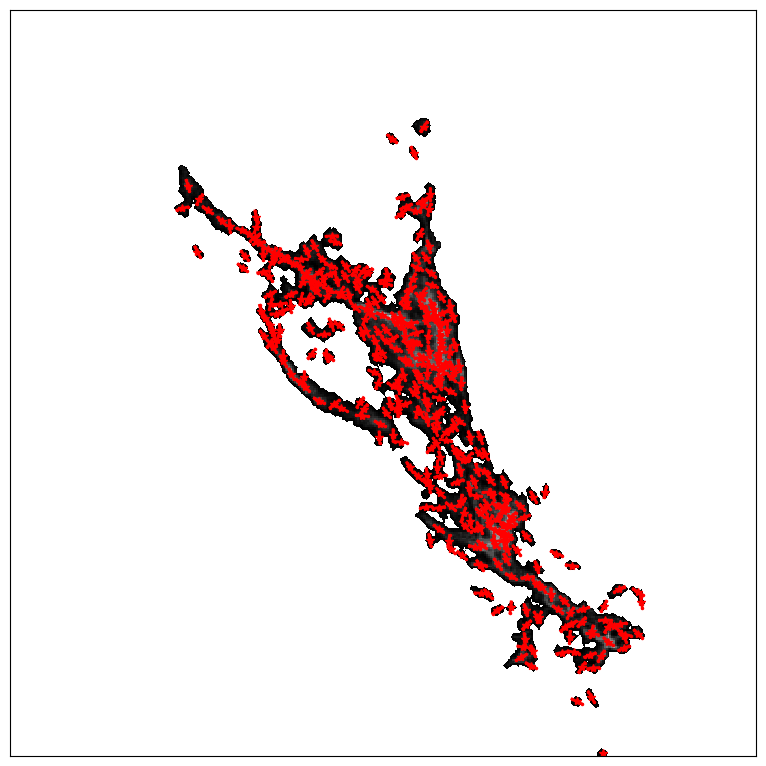

In [23]:
save_path = '../Images/Clumps_Infor.pdf'
Plot_and_Save_Funs.Plot_Clumps_Infor(clumpsObj,figsize=(12,8),line_scale=3,save_path=None)

In [22]:
clump_angles = clumpsObj.angles
clump_edges = clumpsObj.edges
clump_centers = clumpsObj.centers
clump_centers_wcs = clumpsObj.centers_wcs
origin_data = clumpsObj.origin_data
regions_data = clumpsObj.regions_data
data_wcs = clumpsObj.data_wcs
connected_ids_dict = clumpsObj.connected_ids_dict
clump_coords_dict = clumpsObj.clump_coords_dict

clumps_data = np.zeros_like(origin_data)
clumps_data[regions_data>0] = origin_data[regions_data>0]

In [24]:
def Cal_Related_Ids(clump_centers_wcs):
    my_dL = .1
    my_dV = 2

    lbv = clump_centers_wcs
    l,b,v = lbv[:,0], lbv[:,1], lbv[:,2]
    P = lbv[:,0:2] # 2d position l,b

    X = squareform(pdist(P))
    max_length = np.percentile(pdist(P), 25) 

    # weight distance with velocity difference
    for i in range(0,X.shape[0]):
        for j in range(0,X.shape[0]):
            dv = abs(v[i] - v[j])
            if (dv > my_dV) & (X[i,j] < 1*my_dL):
                X[i,j] = X[i,j]*dv                 

    branch_list = minimum_spanning_tree(X,v)
    clump_index_record = []
    for branch in branch_list:
        if len(branch)>1: 
            branch = np.vstack(branch)
#         print ('plotting branch has # of clumps:', len(branch)+1)
#         print (branch)

        # all clumps in this filament
        clump_indexs = np.unique(np.array(branch))
        clump_index_record.append(clump_indexs)
        ci = clump_indexs
        l_wt = np.sum( l[ci] * v[ci] ) / np.sum(v[ci])
        b_wt = np.sum( b[ci] * v[ci] ) / np.sum(v[ci])
        
    return clump_index_record,branch_list

def Plot_Clumps_Infor_By_Ids(clumpsObj,clump_ids,figsize=(8,6),fontsize=14,line_scale=3,save_path=None):
    
    clump_angles = clumpsObj.angles
    clump_edges = clumpsObj.edges
    clump_centers = clumpsObj.centers
    clump_centers_wcs = clumpsObj.centers_wcs
    origin_data = clumpsObj.origin_data
    regions_data = clumpsObj.regions_data
    data_wcs = clumpsObj.data_wcs
    connected_ids_dict = clumpsObj.connected_ids_dict
    clump_coords_dict = clumpsObj.clump_coords_dict
    
    filament_coords, filament_item, data_wcs_item, regions_data_T, start_coords, \
                 filament_item_mask_2D, lb_area = FCFA.Filament_Coords(origin_data, \
                 regions_data, data_wcs, clump_coords_dict, clump_ids, CalSub=False)
    
    fig = plt.figure(figsize=figsize)
    ax0 = fig.add_subplot(111,projection=data_wcs_item.celestial)
    for index in clump_ids:
        center_x = clump_centers[index][1]-start_coords[1]
        center_y = clump_centers[index][2]-start_coords[2]
        cen_x1 = center_x + line_scale*np.sin(np.deg2rad(clump_angles[index]))
        cen_y1 = center_y + line_scale*np.cos(np.deg2rad(clump_angles[index]))
        cen_x2 = center_x - line_scale*np.sin(np.deg2rad(clump_angles[index]))
        cen_y2 = center_y - line_scale*np.cos(np.deg2rad(clump_angles[index]))
        if clump_edges[index] == 0:
            lines = plt.plot([cen_y1,center_y,cen_y2],[cen_x1,center_x,cen_x2])
            plt.setp(lines[0], linewidth=2,color = 'red',marker='.',markersize=3)
        ax0.plot(center_y,center_x,'r*',markersize = 6)
#         ax0.text(center_y,center_x,"{}".format(index),color='r',fontsize=10)
    ax0.imshow(filament_item.sum(0),
               origin='lower',
               cmap='gray',
               interpolation='none')
    ax0.contourf(filament_item.sum(0),
                 levels = [0., .1],
                 colors = 'w')
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.color'] = 'green'
    plt.rcParams['ytick.color'] = 'green'
    plt.xlabel("Galactic Longitude",fontsize=fontsize)
    plt.ylabel("Galactic Latitude",fontsize=fontsize)
    lon = ax0.coords[0]
    lat = ax0.coords[1]
    lon.set_major_formatter("d.d")
    lat.set_major_formatter("d.d")
#     ax0.set_xlim(200, 550)
#     ax0.set_ylim(600, 850)
#     fig.tight_layout()
#     plt.xticks([]),plt.yticks([])
    if save_path!=None:
        plt.savefig(save_path, format='pdf', dpi=1000)
    plt.show()

In [25]:
start_1 = time.time()

clump_index_record,branch_list = Cal_Related_Ids(clump_centers_wcs)

end_1 = time.time()
delta_time = np.around(end_1 - start_1, 2)
print('Total Time:', delta_time)
print('Number:',len(clump_index_record))

Total Time: 0.12
Number: 17


show_id: 0
length: 5


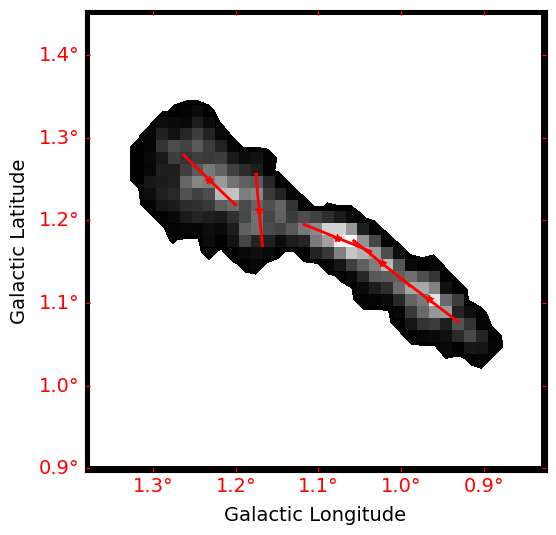

show_id: 1
length: 9


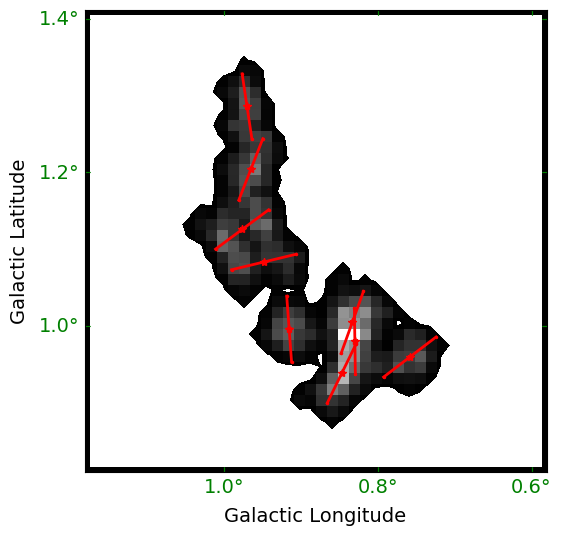

show_id: 2
length: 6


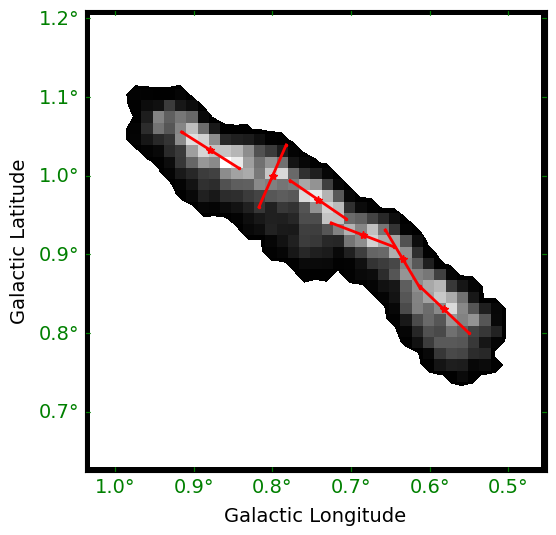

show_id: 3
length: 18


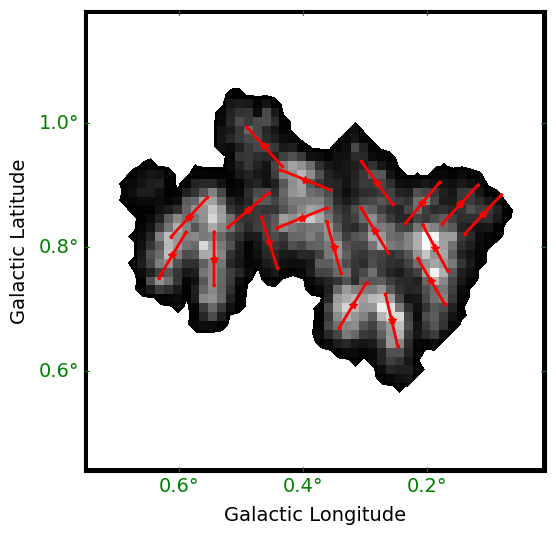

show_id: 4
length: 11


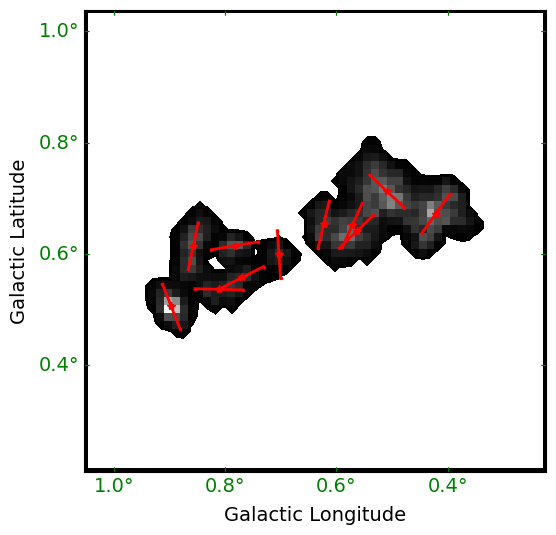

show_id: 5
length: 5


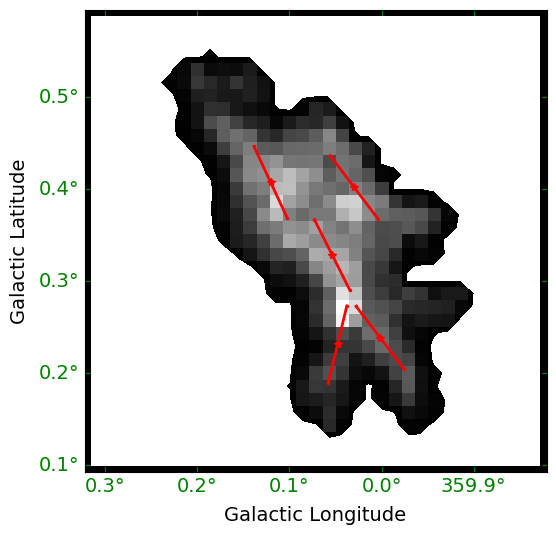

show_id: 6
length: 7


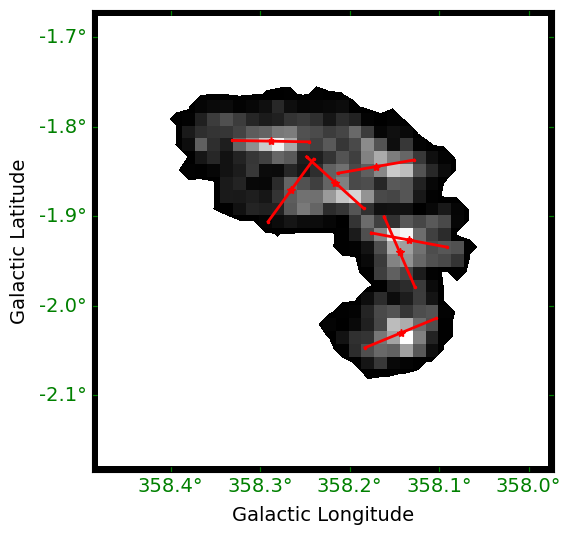

show_id: 7
length: 33


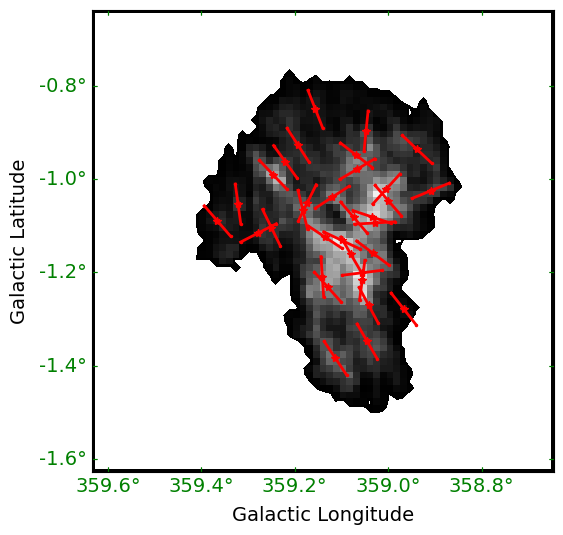

show_id: 8
length: 5


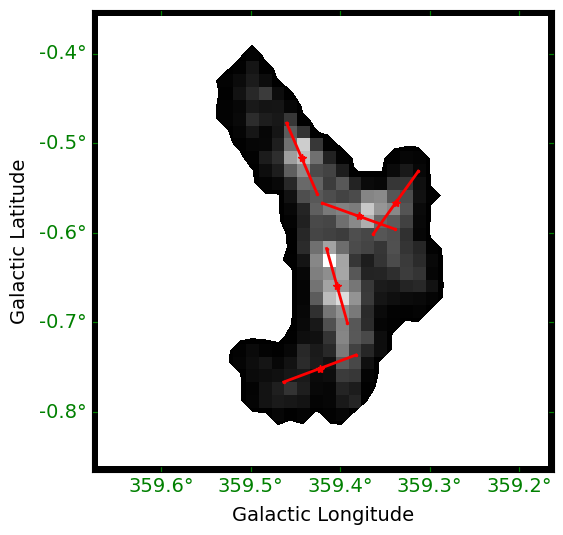

show_id: 9
length: 9


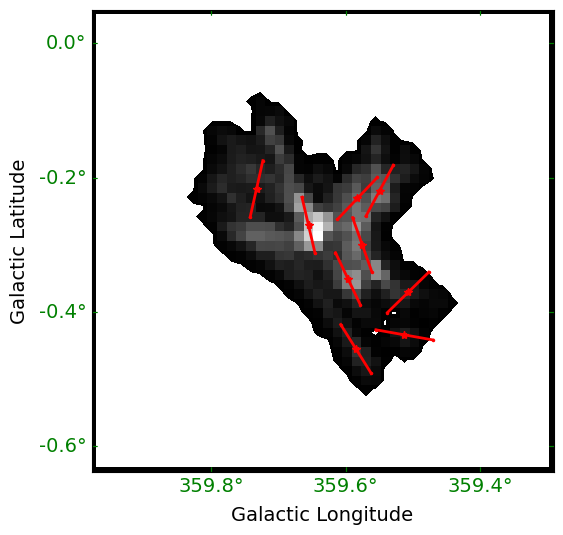

show_id: 10
length: 36


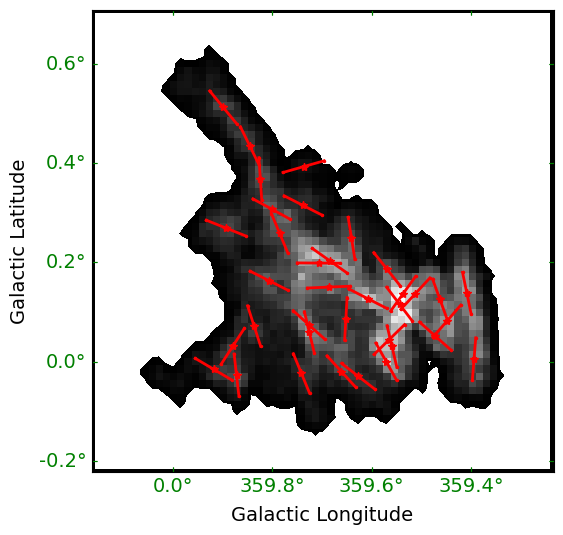

show_id: 11
length: 18


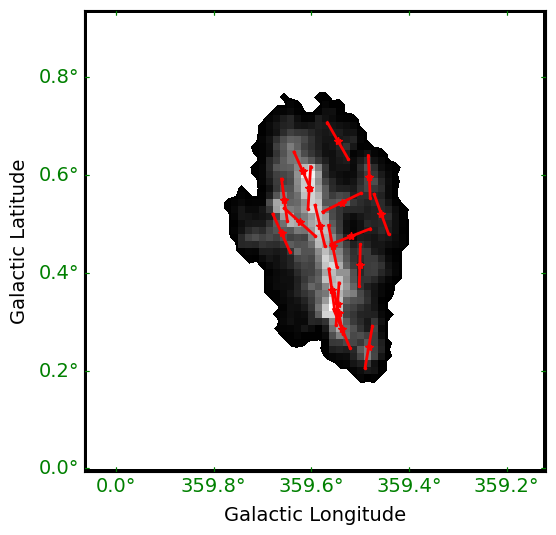

show_id: 12
length: 7


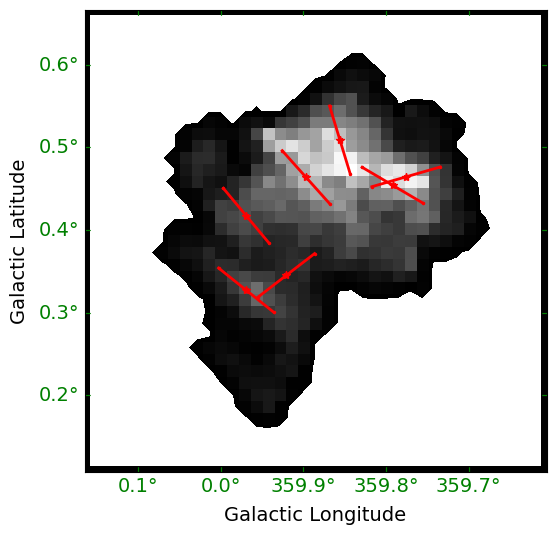

show_id: 13
length: 5


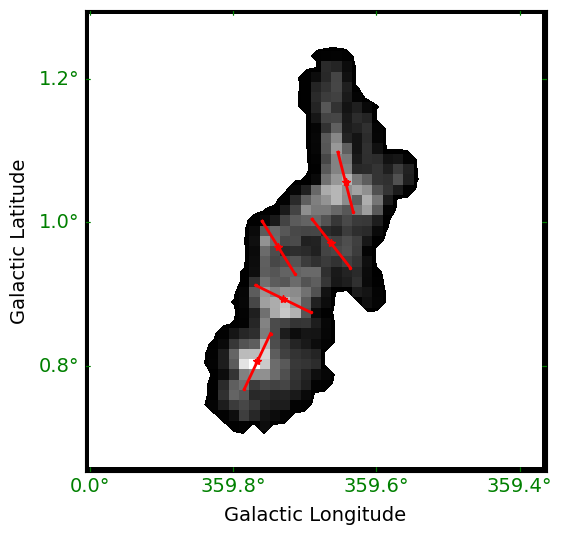

show_id: 14
length: 6


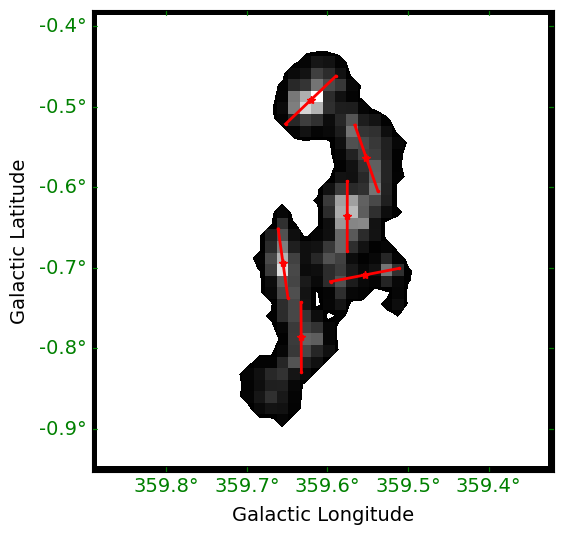

show_id: 15
length: 5


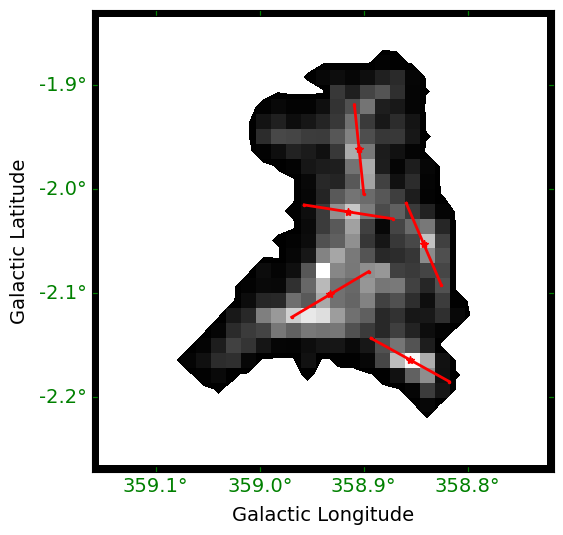

show_id: 16
length: 8


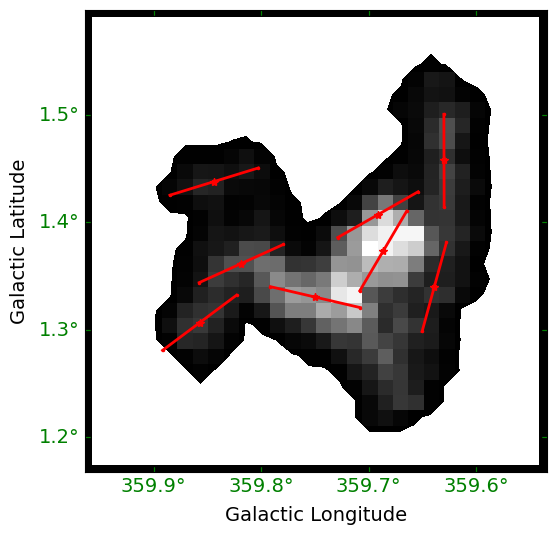

In [26]:
for show_id in range(len(clump_index_record)):
    print('show_id:',show_id)
    filament_clumps_id = clump_index_record[show_id]
    print('length:',len(filament_clumps_id))
    filament_centers_LB = clump_centers[filament_clumps_id][:,1:][::-1]
    Plot_Clumps_Infor_By_Ids(clumpsObj,filament_clumps_id,line_scale=3,save_path=None)

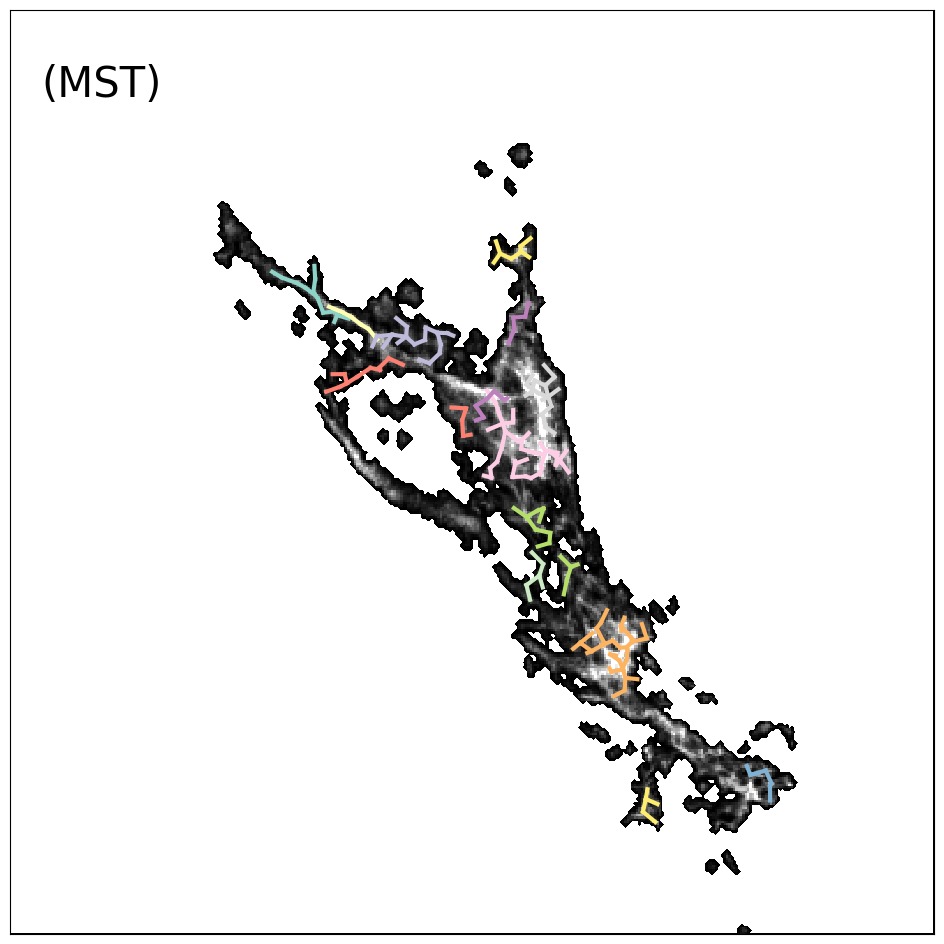

In [28]:
fontsize = 30
fig = plt.figure(figsize=(14,12))
ax0 = fig.add_subplot(111)#,projection=data_wcs.celestial)

ax0.text(13,362,r'({})'.format('MST'),color='black',fontsize=fontsize)

vmin = np.min(clumps_data.sum(0)[np.where(clumps_data.sum(0)!=0)])
vmax = np.nanpercentile(clumps_data.sum(0)[np.where(clumps_data.sum(0)!=0)], 98.)
img = ax0.imshow(clumps_data.sum(0),
                 origin='lower',
           cmap='gray',
           interpolation='none',
           norm = colors.Normalize(vmin = vmin, vmax =  vmax))
ax0.contourf(clumps_data.sum(0),
             levels = [-0.01, .0],
             colors = 'w')

edge_colors = plt.cm.Set3(np.linspace(0, 1, len(clump_index_record)))#plt.cm.Dark2(np.linspace(0, 1, 17)

P = clump_centers[:,1:3]
number = 0
for branch in branch_list:
    if len(branch)>1: 
        branch = np.vstack(branch)
        for edge in branch:
            i, j = edge
            ax0.plot([P[i, 1], P[j, 1]],[P[i, 0], P[j, 0]],  c=edge_colors[number], lw=3, alpha=1)    
        number += 1

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.color'] = 'red'
plt.rcParams['ytick.color'] = 'red'
# plt.xlabel("Galactic Longitude",fontsize=fontsize)
# plt.ylabel("Galactic Latitude",fontsize=fontsize)

plt.xticks([]),plt.yticks([])

# plt.savefig('../Images/HD_MST.pdf', format='pdf', dpi=1000)
plt.show()